<a href="https://colab.research.google.com/github/sirocco77/AccelStepper/blob/master/Copia_de_comparacionseriestimevisualizacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

from itertools import combinations

from scipy import stats
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


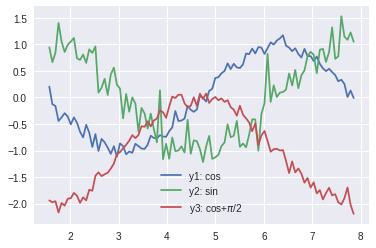

In [11]:
N = 100
x = np.linspace(np.pi/2, 2.5*np.pi, N)

n1 = np.random.normal(0, 0.1, N)
n2 = np.random.normal(0, 0.25, N)
n3 = np.random.normal(-1., 0.1, N)

y1 = np.cos(x) + n1
y2 = np.sin(x) + n2
y3 = np.cos(x+np.pi/2) + n3

plt.plot(x, y1, label='y1: cos')
plt.plot(x, y2, label='y2: sin')
plt.plot(x, y3, label='y3: cos+$\pi$/2')
plt.legend()

In [12]:
# absolutely not stationary
_, p1, *_ = ts.adfuller(y1)
_, p2, *_ = ts.adfuller(y2)
_, p3, *_ = ts.adfuller(y3)
p1,p2,p3

(0.00913884916208248, 0.7946870713664287, 0.010911422203712088)

In [0]:
dates = pd.date_range('2000-1-1', periods=N, freq='D')

ts1 = pd.Series(y1, index=dates)
ts2 = pd.Series(y2, index=dates)
ts3 = pd.Series(y3, index=dates)

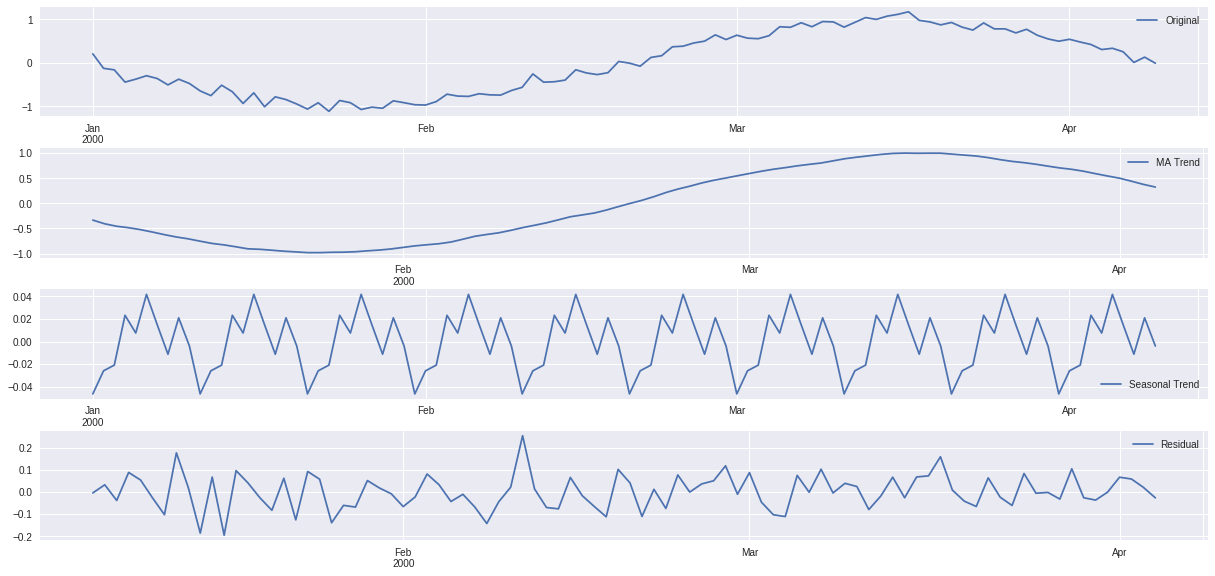

In [15]:
d1 = seasonal_decompose(ts1, freq=10)

fig,axes = plt.subplots(nrows=4, figsize=(17,8))
fig.tight_layout()

ts1.plot.line(ax=axes[0], label='Original', legend=True)
d1.trend.plot.line(ax=axes[1], label='MA Trend', legend=True)
d1.seasonal.plot.line(ax=axes[2], label='Seasonal Trend', legend=True)
d1.resid.plot.line(ax=axes[3], label='Residual', legend=True)

In [16]:
r1 = seasonal_decompose(ts1).resid
r2 = seasonal_decompose(ts2).resid
r3 = seasonal_decompose(ts3).resid


## r1 and r3 are statistically similar!!
for a,b in combinations((r1,r2,r3), 2):
    _,p = stats.ks_2samp(a,b)
    print(p)

0.0030312451667524882
0.9921018394783478
0.00017421323105301873


We've proven that `ts1` and `ts3` have similar redisuals 
But, are the trends linearly displaced?
Granger causality null hypothesis

The Null hypothesis for grangercausalitytests is that the time series in the second column, x2, does NOT cause the time series in the first column, x1. Grange causality means that past values of x2 have a statistically significant effect on the current value of x1, taking past values of x1 into account as regressors. We reject the null hypothesis that x2 does NOT cause x1 if the pvalues are below a desired size of the test.

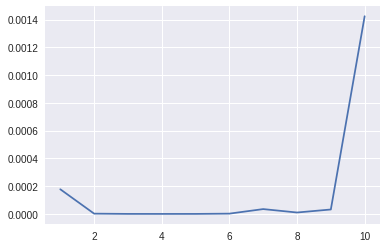

In [17]:
df = pd.concat((ts1, ts3), axis='columns').dropna()

result = ts.grangercausalitytests(df, maxlag=10, verbose=False)
p_values = pd.Series({k:v[0]['lrtest'][1] for k,v in result.items()})

p_values.plot.line()

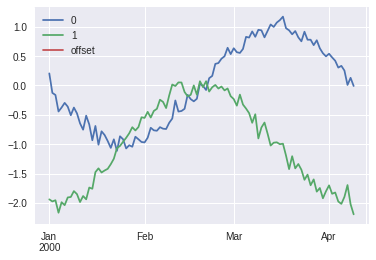

In [18]:
df['offset'] = df[0].shift(-250)
df.plot.line()